<div style="font-weight:bold;font-size:30px;margin-bottom:-5px">Labs Submission 3: Ensemble learning</div>

*submitted by: Lixiao Hu, Moritz Raykowski and Robin Reiners*

---

<p style="font-weight: bold">Table of Content:</p>

* [Problem Definition 1: Ensemble learning](#ensemble-learning)
    * [1. Question](#1-1)
    * [2. Question](#1-2)
    * [3. Question](#1-3)
    * [4. Question](#1-4)
    * [5. Question](#1-5)
    * [6. Question](#1-6)
    * [7. Question](#1-7)
    * [8. Question](#1-8)
    * [9. Question](#1-9)
    * [10. Question](#1-10)

---

*install required dependencies:*

In [1]:
import json
import importlib

from math import ceil

def import_or_install(package):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        import subprocess
        subprocess.check_call(['pip', 'install', package])
        print(f"{package} has been installed.")


libraries = ['numpy', 'pandas', 'matplotlib', 'seaborn']

for library in libraries:
    import_or_install(library)
    globals()[library] = importlib.import_module(library)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
from matplotlib.ticker import PercentFormatter

# Display the plot centered within the cell
display(HTML("<style>.output { display: flex; justify-content: center; }</style>"))

numpy is already installed.
pandas is already installed.
matplotlib is already installed.
seaborn is already installed.


<a id='ensemble-learning'></a> <p style="text-decoration: underline; font-style: italic; font-size:24px">Problem Definition: Ensemble learning</p>

A key question in recent research on inequality concerns the accurate measurement of wealth across individuals. Because of sampling issues, information is hard to come by, especially at the top of the wealth distribution. The Survey of Consumer Finances is a tri-annual survey about household finances in the US conducted by the Federal Reserve. Among many other uses, the survey is used to estimate the wealth distribution in the US (see [here](#https://www.sciencedirect.com/science/article/pii/S0165176519303295) for a recent study).

To make sure that wealthy individuals are sampled, the sampling design of the survey is not random but also includes a list of potentially wealthy citizens. The way that this list is created is described [here](#https://www.brookings.edu/wp-content/uploads/2016/03/brickerappendixspring16bpea.pdf) in detail and we will focus on the *empirical correlation model*: The basic idea is to predict wealth from income, and then use administrative income data (which are much easier to get from tax returns) to make wealth predictions. Individuals with high predicted wealth are then added to the list *sample* of the survey. In other words, the list sample is based on a regression of
$$
Wealth_{i} = f(Income_{i}) + ϵ_{i}
$$
The actual model uses past administrative income data but we will use income as reported in the SCF directly (The actual model is described on page 6 of the aforementioned paper). The way that wealth is measured in the SCF is itself not trivial (see this [flowchart](#https://www.federalreserve.gov/econres/files/Networth%20Flowchart.pdf)) but for our purposes we just take those data
as given.

Our goal is to come up with a good model for wealth using available information in the SCF. In addition to income data, we will also make use of a couple of individual characteristics. The most recent survey had about 6000 respondents and data are available for download [here](#https://www.federalreserve.gov/econres/scfindex.htm). To get a sense of what kind of information can be extracted from the survey, see a recent [Federal Reserve Bulletin](#https://www.federalreserve.gov/publications/files/scf17.pdf).

I put a pre-formatted version of the most recent survey data for you to use for this lab on the course website (```Lab3_EnsembleLearning.csv```). The variable that we want to predict is ``logWealth`` and all other variables can be used as potential predictors. (FYI: The variable names are the original variable names in
the underlying survey data, and variable descriptions are included in this [rather long original file](#https://www.federalreserve.gov/econres/files/bulletin.macro.txt).)

<p style="text-decoration: underline" id='1-1'>Lab-Question 1:</p>

*Familiarize yourself with the data using visual exploration and discuss your findings.*

---

**Answer:** 



In [2]:
data = pd.read_csv('data\Lab3_EnsembleLearning.csv', sep=";")
data['wealth'] = np.e**data.logWealth

|   hhsex |   age |   educ |   married |   kids |   lf |   famstruct |   race |   OCCAT1 |   OCCAT2 |   income |   wageinc |   bussefarminc |   intdivinc |   kginc |   ssretinc |   transfothinc |   norminc |   knowl |   logWealth |   logIncome |   Wealth |
|--------:|------:|-------:|----------:|-------:|-----:|------------:|-------:|---------:|---------:|---------:|----------:|---------------:|------------:|--------:|-----------:|---------------:|----------:|--------:|------------:|------------:|---------:|
|       1 |    71 |     10 |         2 |      0 |    0 |           3 |      1 |        3 |        4 |  13164.3 |       0   |              0 |        0    |       0 |    9113.73 |        3949.28 |   13164.3 |      10 |    12.0829  |     9.48526 |   176830 |
|       0 |    20 |      8 |         1 |      0 |    1 |           5 |      3 |        4 |        4 |  22278   |   19240.1 |              0 |        0    |       0 |       0    |        3442.96 |   22278   |       8 |     2.30259 |    10.0114  |       10 |
|       0 |    30 |      9 |         1 |      2 |    1 |           4 |      1 |        1 |        2 | 112403   |  108352   |              0 |     2531.59 |       0 |       0    |        1518.95 |  112403   |       8 |    12.6277  |    11.6298  |   304900 |
|       1 |    33 |      8 |         2 |      2 |    1 |           1 |      3 |        1 |        2 |  42530.7 |   42530.7 |              0 |        0    |       0 |       0    |           0    |   42530.7 |       7 |    10.5795  |    10.658   |    39320 |
|       0 |    41 |     13 |         1 |      1 |    1 |           4 |      1 |        1 |        1 | 114428   |  114428   |              0 |        0    |       0 |       0    |           0    |  114428   |       7 |    11.7776  |    11.6477  |   130300 |

|    Column    |                                 Description                                 |    Column    |                                 Description                                 |
|--------------|-----------------------------------------------------------------------------|--------------|------------------------------------------------------------------------------|
|    hhsex     |             Gender of the individual (0 for female, 1 for male)             |     age      |                            Age of the individual                            |
|     educ     |                  Education level of the individual (yrs of ed)              |   married    |               Marital status (1 for married, 2 for unmarried)               |
|     kids     |                              Number of children                             |      lf      | Labor force status (0 for not in the labor force, 1 for in the labor force) |
|  famstruct   |                               Family structure                              |     race     |                            Race of the individual                           |
|    OCCAT1    |                            Occupation category 1                            |    OCCAT2    |                            Occupation category 2                            |
|    income    |                                 Total income                                |   wageinc    |                              Income from wages                              |
| bussefarminc |                       Income from business or farming                       |  intdivinc   |                            Income from dividends                            |
|    kginc     |                         Income from investment gains                        |   ssretinc   |               Income from Social Security retirement benefits               |
| transfothinc |                          Income from other sources                          |   norminc    |                              Normalized income                              |
|    knowl     |                        knowledge of personal finance                        |  logWealth   |                             Logarithm of wealth                             |

In [3]:
# Read the JSON data from the file
file_path = "data\Lab3_Categories.json"

with open(file_path, 'r') as file:
    json_data = file.read()

# Convert the JSON data to a dictionary
meta_data = json.loads(json_data, parse_int=int)

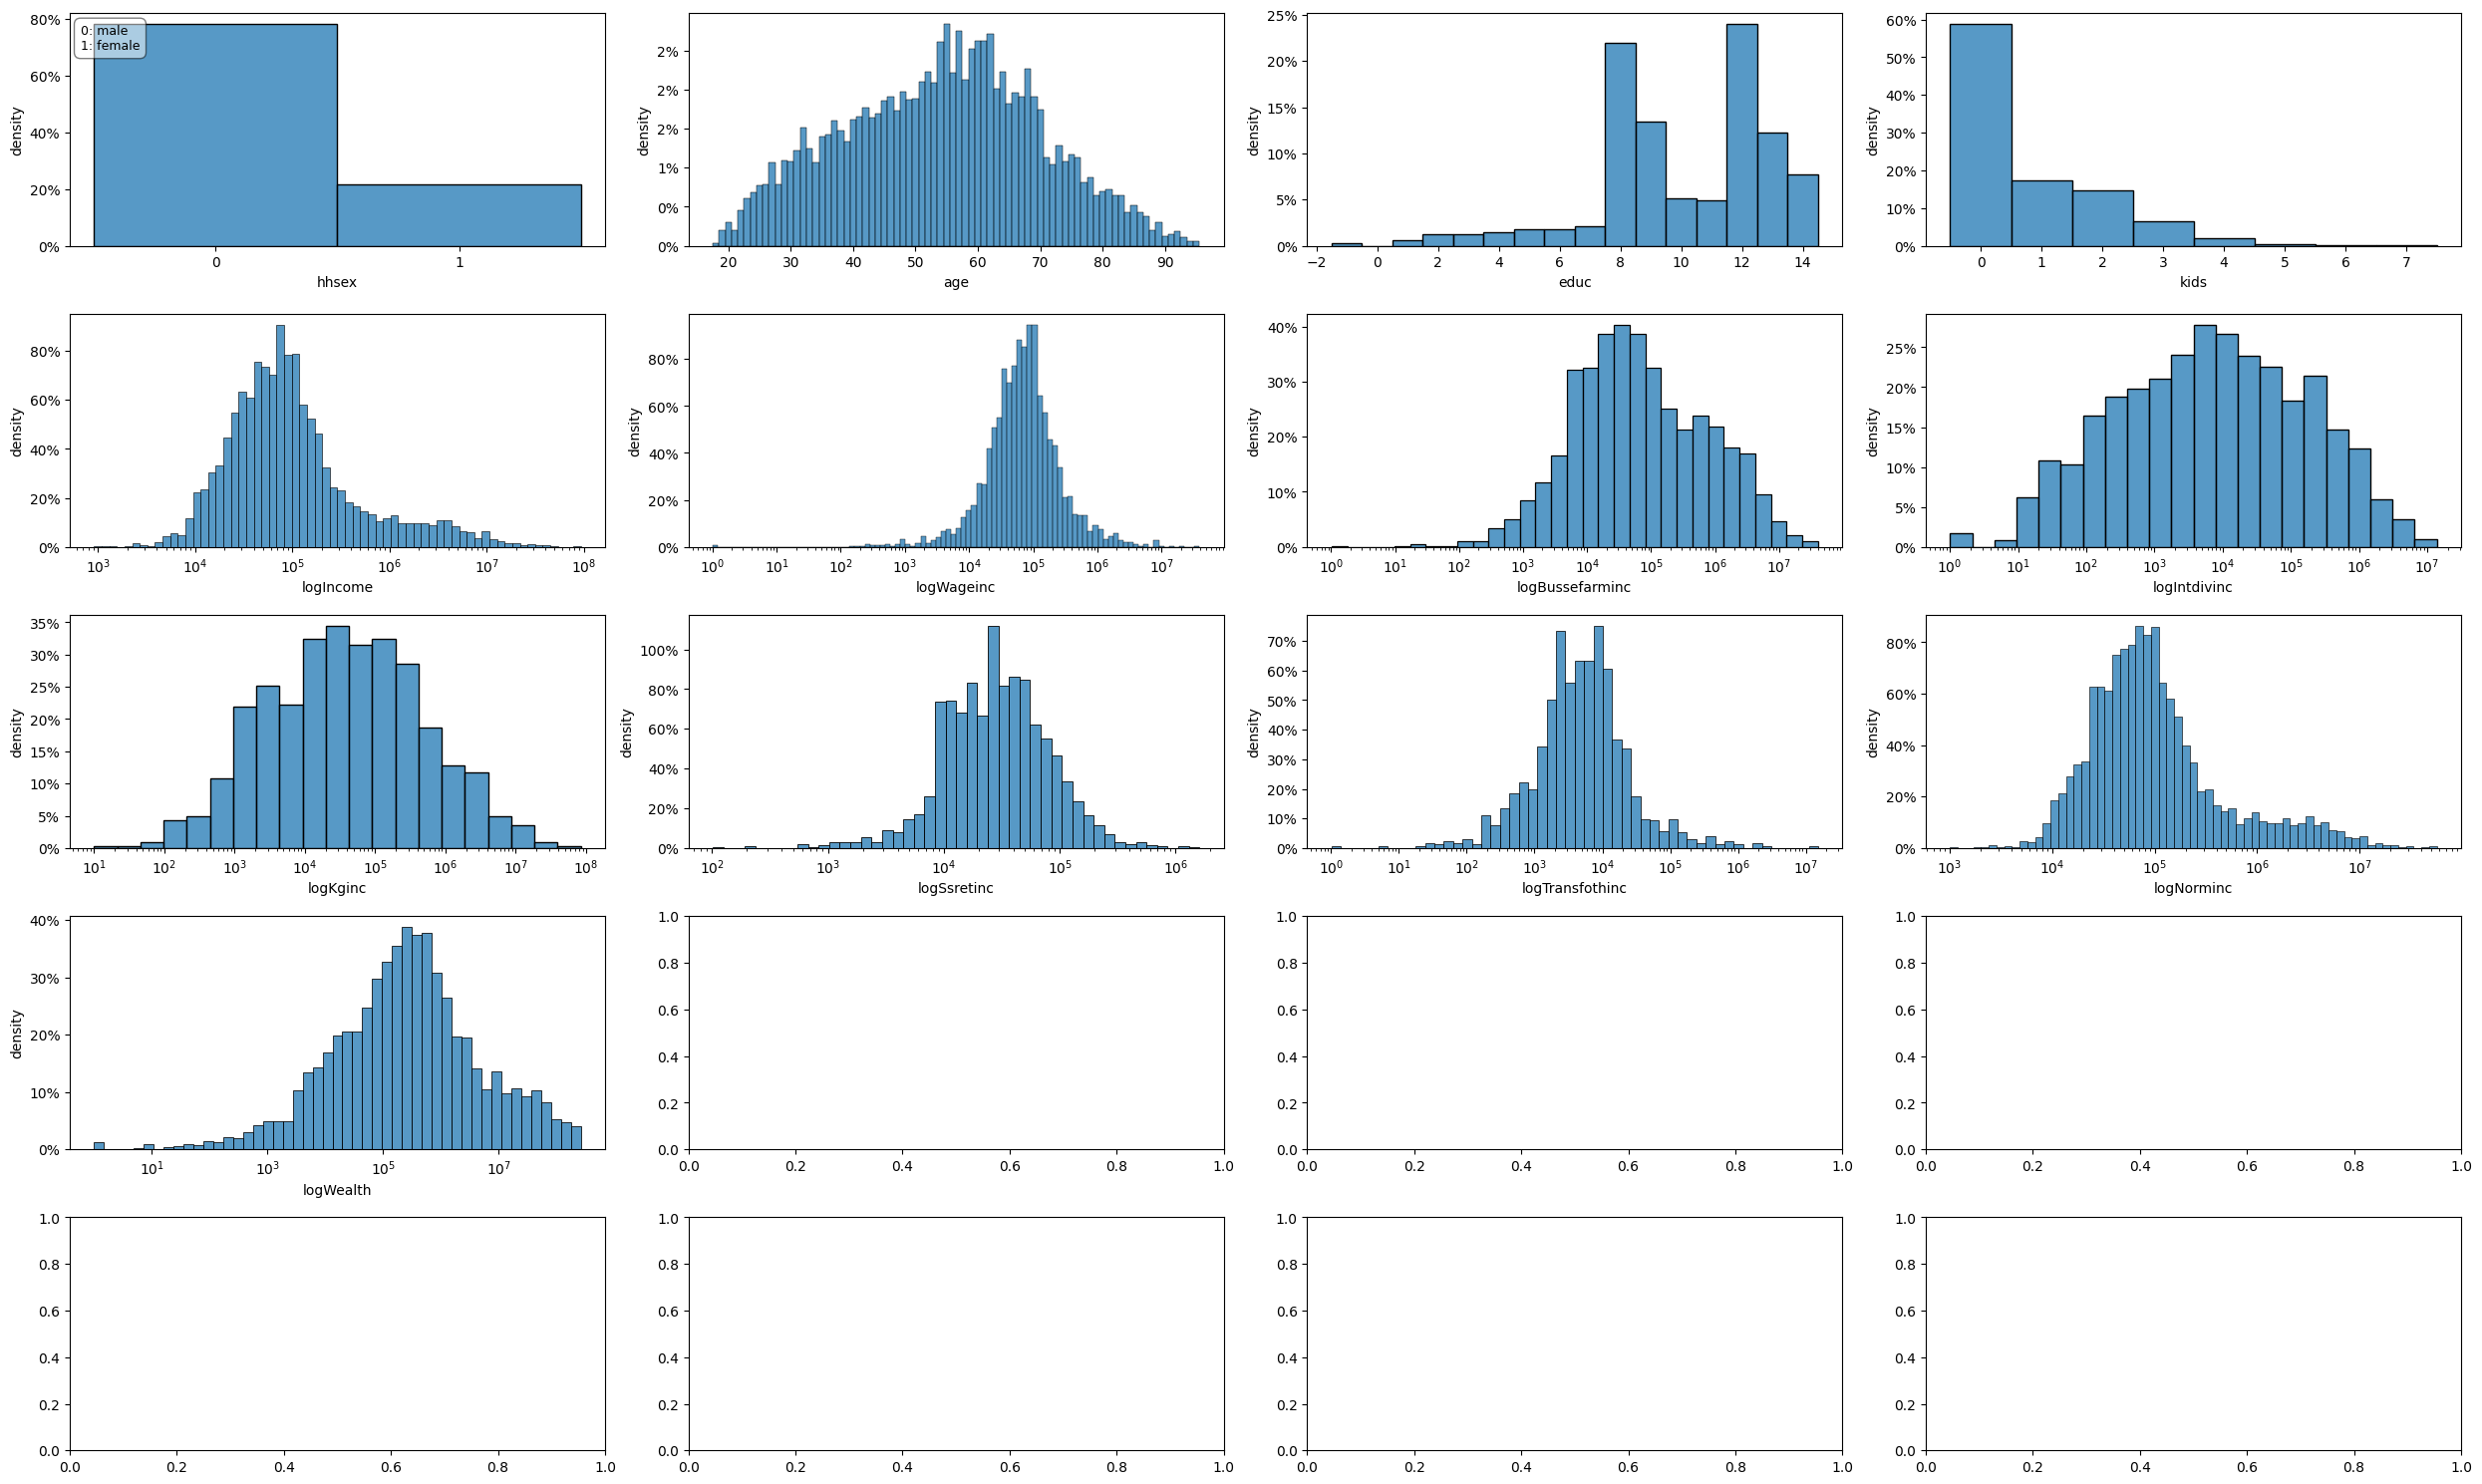

In [4]:
# Categorical Variables
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(25, 15))

# Flatten the axes for easier iteration
axs = axs.flatten()

for i, (feature, values) in enumerate(meta_data['categories'].items()):
    sns.histplot(data=data, x=feature, ax=axs[i], discrete=True, legend=True, stat='density', common_norm=True)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('density')
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[i].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

    encoding_info = '\n'.join([f'{key}: {values[key]}' for key in sorted(values.keys())])
    textbox = axs[i].text(0.02, 0.95, encoding_info, transform=axs[i].transAxes,
                          verticalalignment='top', fontsize=9, bbox={'boxstyle': 'round', 'alpha':0.5,'facecolor': 'white',
                                                                        'edgecolor': 'black', 'pad': 0.5})
    textbox.set_multialignment('left')
    
for j, feature in enumerate(meta_data['numeric'], start=i+1):
    sns.histplot(data=data, x=feature, ax=axs[j], discrete=True, legend=True, stat='density')

    axs[j].set_xlabel(feature)
    axs[j].set_ylabel('density')
    axs[j].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    
for k, feature in enumerate(meta_data['incomes'], start=j+1):
    sns.histplot(data=data.query(f'{feature}>0'), x=feature, ax=axs[k], log_scale=True, legend=True, stat='density')

    axs[k].set_xlabel(f'log{feature.capitalize()}')
    axs[k].set_ylabel('density')
    axs[k].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

plt.tight_layout()
plt.show()

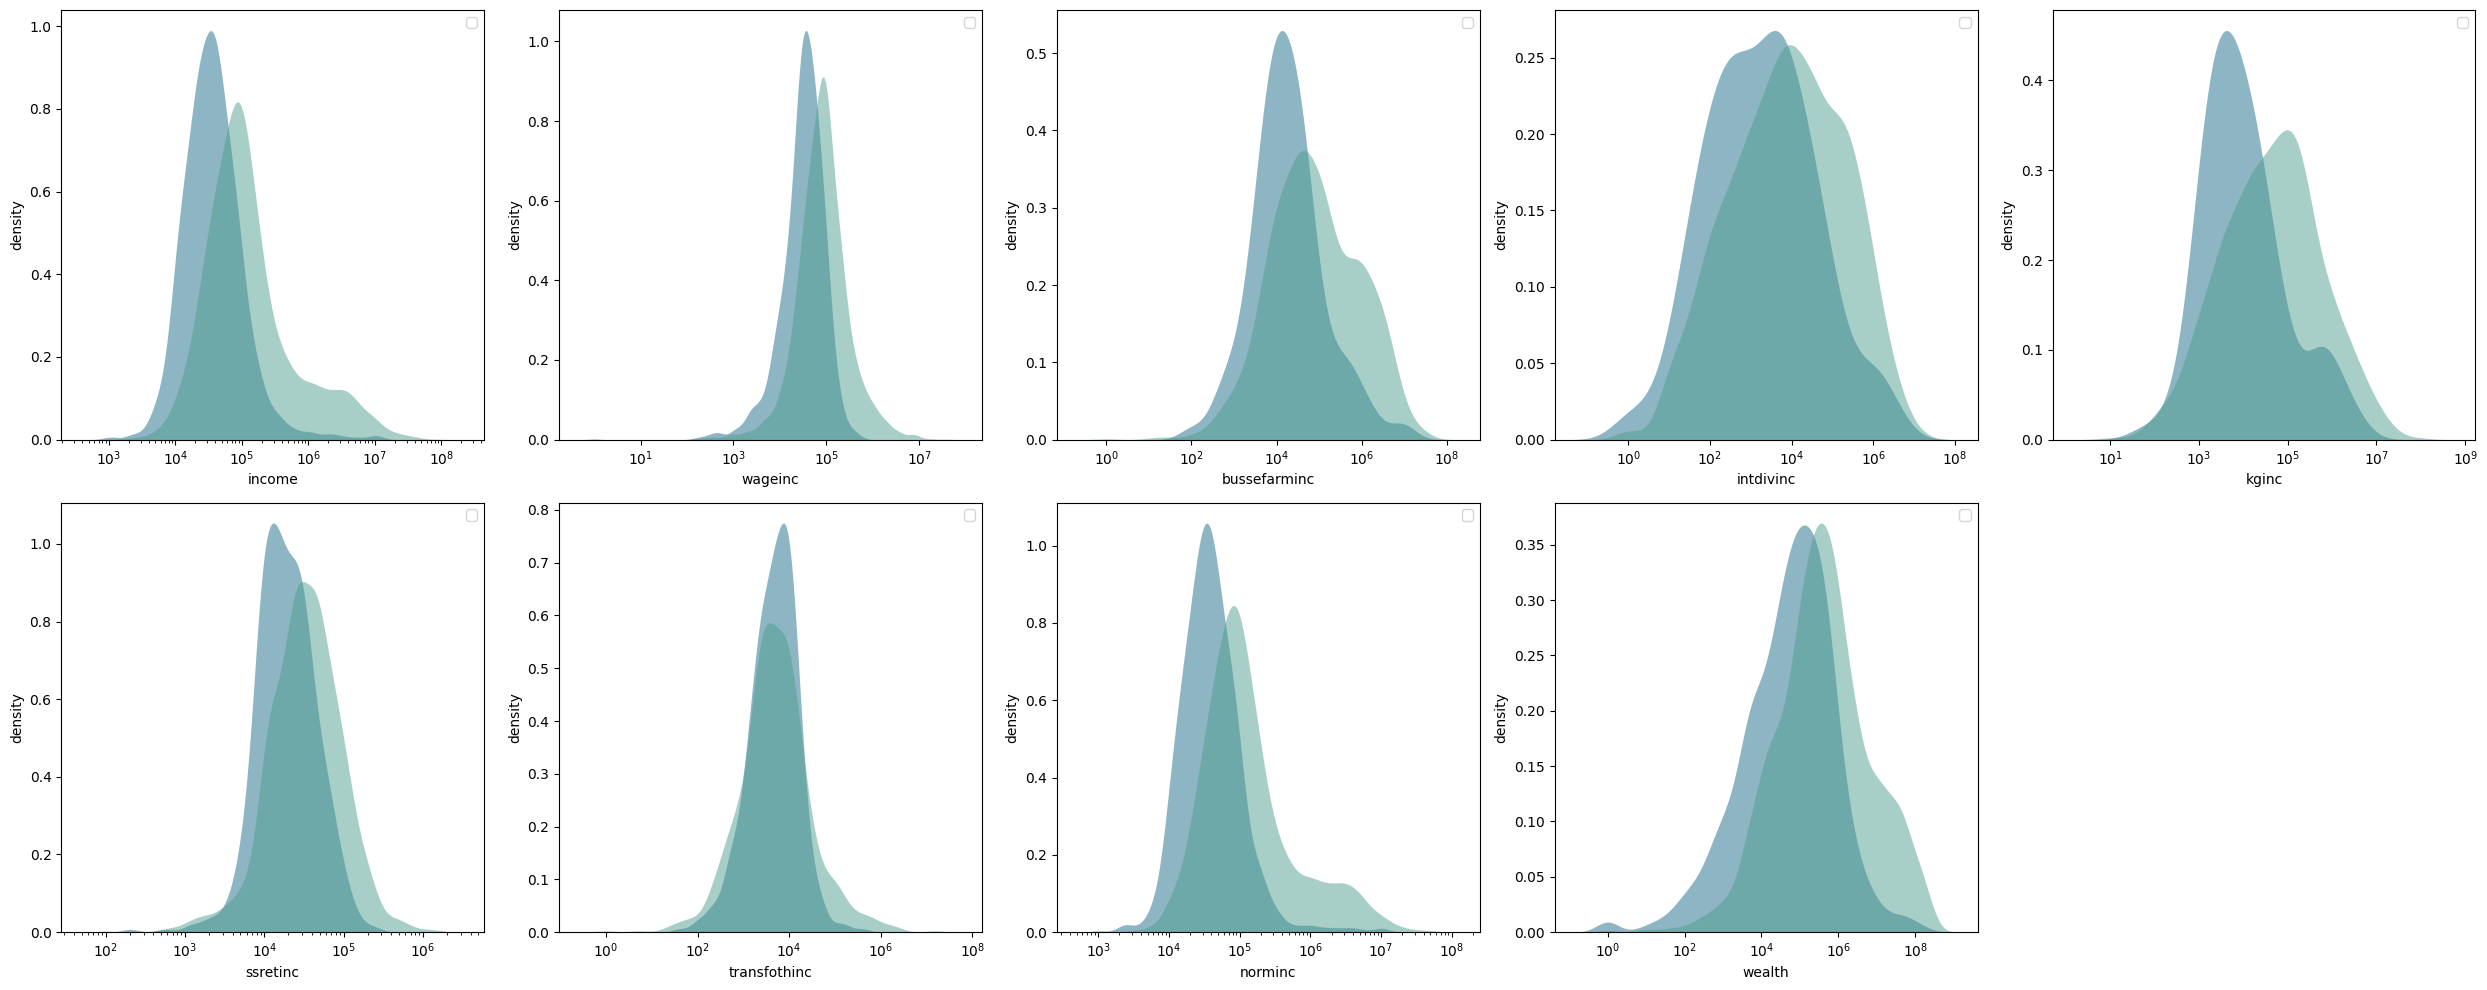

In [15]:
import math
import matplotlib.pyplot as plt

hues = meta_data['categories']
income_keys = meta_data['incomes']
num_plots = len(income_keys)

# Calculate the number of rows and columns based on the number of plots
num_cols = 5
num_rows = math.ceil(num_plots / num_cols)

for hue in hues.keys():
    # Create the figure and axes for the required number of plots
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, num_rows*5))

    # Flatten the axes array
    axs = axs.flatten()

    # Iterate over the plots and income keys
    for i, (ax, income) in enumerate(zip(axs, income_keys)):
        sns.kdeplot(
            data=data.query(f'{income}>0'), x=income, log_scale=True, hue=hue,
            fill=True, common_norm=False, palette="crest", legend=True,
            alpha=.5, linewidth=0, ax=ax
        )
        ax.set_xlabel(income)
        ax.set_ylabel('density')
                
        # # Get the handles and labels from the legend
        handles, legend_labels = ax.get_legend_handles_labels()

        # Create a custom legend with the modified labels
        ax.legend(handles, legend_labels)

    
    for ax in axs[i+1:]:
        fig.delaxes(ax)

    plt.tight_layout()

plt.show()

In [14]:
hues[hue]

{'0': 'male', '1': 'female'}

In [ ]:
# Categorical Variables
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(27, 10))

correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axs)